# Punto 6. Workshop 6

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import shapely

plt.rcParams['figure.figsize'] = (10, 8)

root_folder= r"/home/DATA"


SHAPE_MUN = root_folder+r"/municipios_colombia.shp"
EVA_CSV   = root_folder+'/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder+'/Catalogo_Estaciones_IDEAM.csv'
SHAPE_VIAS = root_folder+r"/vias_colombia_V2.shp"

In [2]:
gdf_vias = gpd.read_file(SHAPE_VIAS).to_crs(epsg=9377)

In [3]:
# Municipalities → GeoDataFrame 
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)

# EVA table, rename code column
eva = (pd.read_csv(EVA_CSV)
         .rename(columns={"CÓD. MUN.": "cod_mun"}))
eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

# IDEAM catalogue → GeoDataFrame (clean "(lat, lon)")
df_est = pd.read_csv(EST_CSV)
coords = (df_est["Ubicación"]
            .str.strip("()")
            .str.split(",", expand=True)
            .astype(float))
df_est["lat"], df_est["lon"] = coords[0], coords[1]

gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows")


#Homogenise municipalities codes
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]        = eva["cod_mun"].astype(str).str.zfill(5)

1,122 municipalities • 8,973 stations • 206,068 EVA rows


# 6.2 Pasos de análisis básicos - Nivel 1: Selección municipal

In [4]:
# Paso 1: Convertir la columna a tipo numérico, manejando posibles errores
# Usa 'int' si sabes que todos son enteros. Si hay decimales, usa 'float'.
# Si hay valores no numéricos, 'errors='coerce'' los convertirá a NaN.
gdf_mun["DPTO_CCDGO_NUM"] = pd.to_numeric(gdf_mun["DPTO_CCDGO"], errors='coerce')

# Paso 2: Filtrar usando la nueva columna numérica
# Aquí es importante asegurarte de que 15 sea el tipo correcto (int) para la comparación
Boyaca = gdf_mun[gdf_mun["DPTO_CCDGO_NUM"] == 15].copy()

# Ahora, verifica si Boyaca está vacío antes de continuar
if Boyaca.empty:
    print("¡Advertencia! No se encontraron municipios para el código de departamento 15.")
    print("Revisa los valores únicos en la columna 'DPTO_CCDGO' de gdf_mun para depurar.")
    # Opcional: mostrar los primeros valores para inspección
    # print(gdf_mun["DPTO_CCDGO"].head())
    # print(gdf_mun["DPTO_CCDGO"].dtype)
else:
    print(f"Se encontraron {len(Boyaca)} municipios para el código 15.")
    Boyaca_bool = gdf_vias.within(Boyaca.geometry.iloc[0])
    Boyaca_vias = gdf_vias[Boyaca_bool]
    print(Boyaca_vias)

Se encontraron 123 municipios para el código 15.
        TIPO_VIA ESTADO_SUP NUMERO_CAR ACCESIBILI NOMBRE_GEO PROYECTO SYMBOL  \
74315          5       3306  Sin Valor       3601       None     None      2   
74324          3       3301       3502       3600       None     None      2   
74325          3       3301       3502       3600       None     None      2   
74326          3       3301       3502       3600       None     None      2   
74327          3       3301       3502       3600       None     None      2   
...          ...        ...        ...        ...        ...      ...    ...   
101513         6       3350  Sin Valor       3601       None     None      2   
101530         5       3306  Sin Valor       3601       None     None      2   
101531         5       3306  Sin Valor       3601       None     None      2   
101599         6       3350  Sin Valor       3601       None     None      2   
101615         6       3350  Sin Valor       3601       None     None  

In [5]:
Boyaca.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,DPTO_CCDGO_NUM
637,15,00001,TUNJA,15001,2018,1.196889e+08,5.518473,-73.378019,79594.0,0.0,...,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001,"POLYGON ((4959760.536 2172167.311, 4959767.787...",15
638,15,00022,ALMEIDA,15022,2018,5.767212e+07,4.954825,-73.388134,2649.0,0.0,...,514.0,83.0,18.0,88.0,16.0,0.348469,0.004702,15022,"POLYGON ((4959230.781 2111994.725, 4959364.58 ...",15
639,15,00047,AQUITANIA,15047,2018,9.421466e+08,5.437416,-72.871495,25311.0,0.0,...,4629.0,669.0,77.0,837.0,106.0,1.800311,0.076844,15047,"POLYGON ((5026299.41 2181056.535, 5026366.975 ...",15
640,15,00051,ARCABUCO,15051,2018,1.378986e+08,5.749565,-73.438880,4414.0,0.0,...,1913.0,461.0,66.0,178.0,28.0,0.752709,0.011257,15051,"POLYGON ((4944132.595 2203718.48, 4944172.143 ...",15
641,15,00087,BELÉN,15087,2018,1.630882e+08,6.005059,-72.893699,8167.0,0.0,...,2581.0,781.0,103.0,289.0,59.0,0.629349,0.013315,15087,"POLYGON ((5009188.804 2230505.691, 5009166.938...",15


In [6]:
Boyaca_poligono = Boyaca.dissolve(by = 'DPTO_CCDGO_NUM')

Boyaca_poligono.head()
print("\nGeoDataFrame Boyaca_poligono (después de dissolve):\n", Boyaca_poligono)


GeoDataFrame Boyaca_poligono (después de dissolve):
                                                          geometry DPTO_CCDGO  \
DPTO_CCDGO_NUM                                                                 
15              POLYGON ((4950411.628 2098204.312, 4950368.451...         15   

               MPIO_CCDGO MPIO_CNMBR MPIO_CDPMP  VERSION          AREA  \
DPTO_CCDGO_NUM                                                           
15                  00001      TUNJA      15001     2018  1.196889e+08   

                 LATITUD   LONGITUD  STCTNENCUE  ...  STP34_9_ED  STP51_PRIM  \
DPTO_CCDGO_NUM                                   ...                           
15              5.518473 -73.378019     79594.0  ...      2820.0     35470.0   

                STP51_SECU  STP51_SUPE  STP51_POST  STP51_13_E  STP51_99_E  \
DPTO_CCDGO_NUM                                                               
15                 56563.0     43652.0     14337.0      3156.0      4044.0   

      


--- Generando el gráfico ---
Vías ploteadas con éxito.


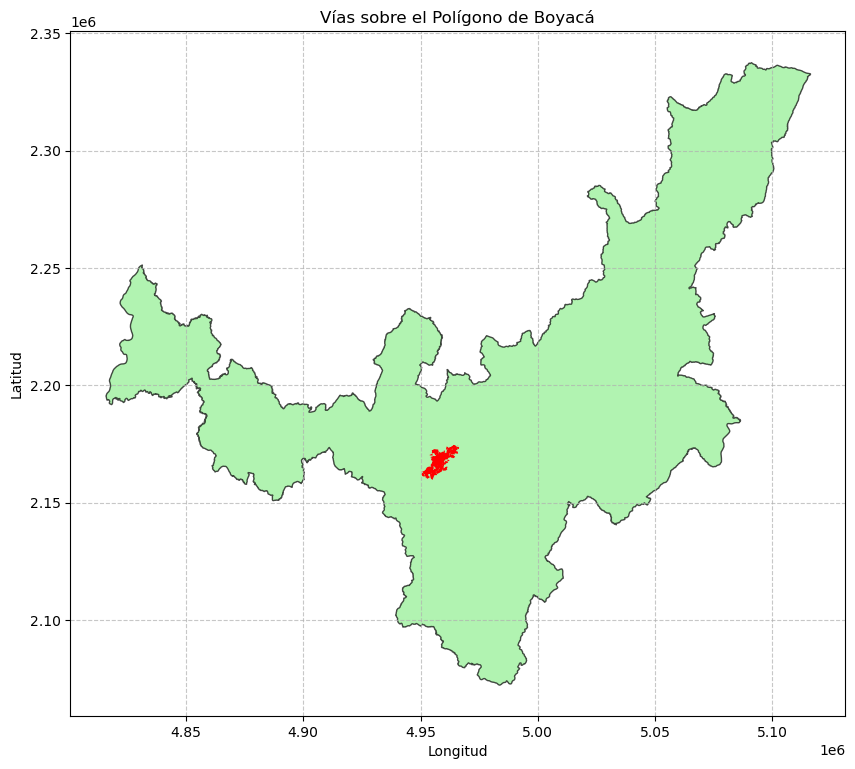

In [7]:
# --- Plotting (Visualización) ---
print("\n--- Generando el gráfico ---")
fig, ax = plt.subplots(1, 1, figsize=(10, 10)) # Crear figura y ejes explícitamente para mejor control

# Plotear el polígono de Boyacá (disuelto)
Boyaca_poligono.plot(ax=ax, color="lightgreen", edgecolor="black", alpha=0.7)

# Plotear las vías de Boyacá encima del polígono
if not Boyaca_vias.empty: # Solo plotea si hay vías
    Boyaca_vias.plot(ax=ax, color="red", linewidth=2)
    print("Vías ploteadas con éxito.")
else:
    print("Advertencia: Boyaca_vias está vacío, no se plotearon vías.")

ax.set_title("Vías sobre el Polígono de Boyacá")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [8]:
Boyaca = gdf_mun[gdf_mun["DPTO_CCDGO"].str.upper().str.contains("15")].copy()
Boyaca_bool = gdf_est.intersects(Boyaca.geometry.iloc[0])
Boyaca_stations = gdf_est[Boyaca_bool]
print(Boyaca_stations)


          Codigo                                             Nombre  \
2018    24035130                                 U P T C [24035130]   
4205  2401500086  UNIVERSIDAD PEDAGÓGICA Y TECNOLÓGICA DE COLOMB...   
6433    24030900                              COL ORTIZ  [24030900]   
6445    24030920                                  TUNJA  [24030920]   
8410    24030910                              SEMINARIO  [24030910]   

                Categoria      Estado Departamento Municipio  \
2018  Climática Principal      Activa       Boyacá     Tunja   
4205  Climática Principal      Activa       Boyacá     Tunja   
6433        Pluviométrica  Suspendida       Boyacá     Tunja   
6445        Pluviométrica  Suspendida       Boyacá     Tunja   
8410        Pluviométrica  Suspendida       Boyacá     Tunja   

                       Ubicación  Altitud Fecha_instalacion Fecha_suspension  \
2018   (5.5430775, -73.36081306)     2690        1962-02-15              NaN   
4205  (5.55361111, -73.35527

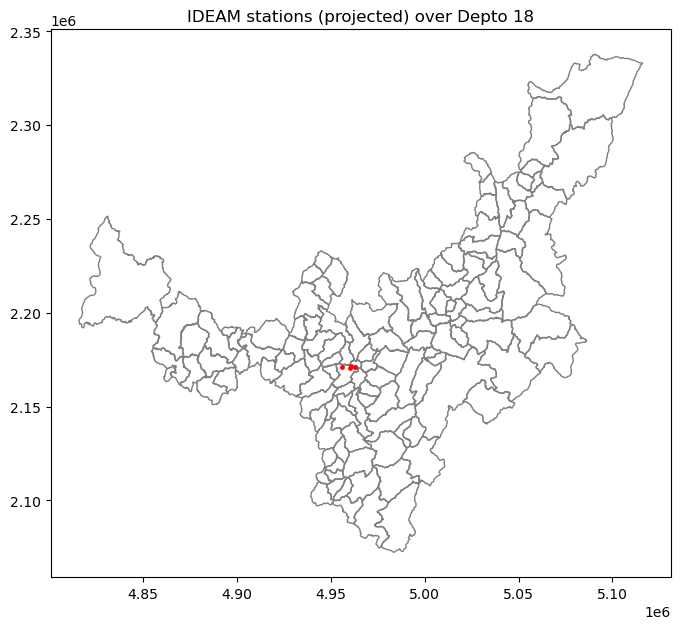

In [9]:
ax = Boyaca.plot(color="none", edgecolor="grey", figsize=(8, 8))
Boyaca_stations.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Depto 18")
plt.show()

In [10]:
Boyaca_poligono = Boyaca.dissolve(by = 'DPTO_CCDGO')


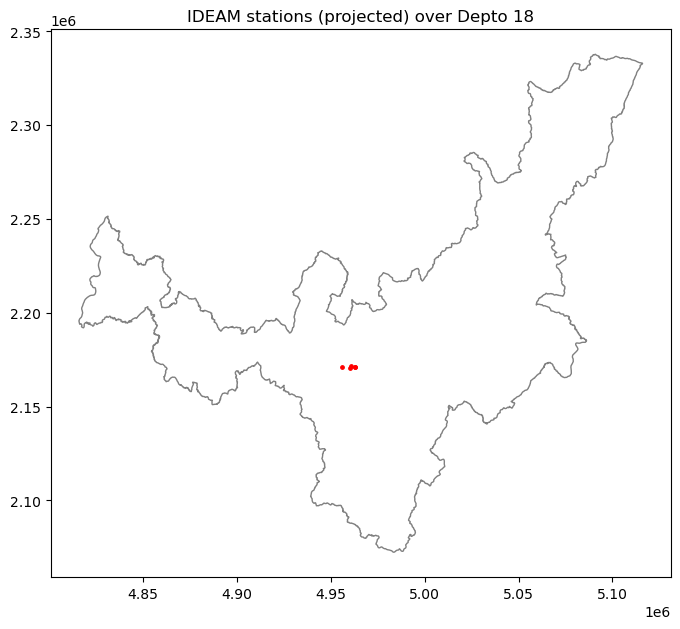

In [11]:
ax = Boyaca_poligono.plot(color="none", edgecolor="grey", figsize=(8, 8))
Boyaca_stations.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Depto 18")
plt.show()

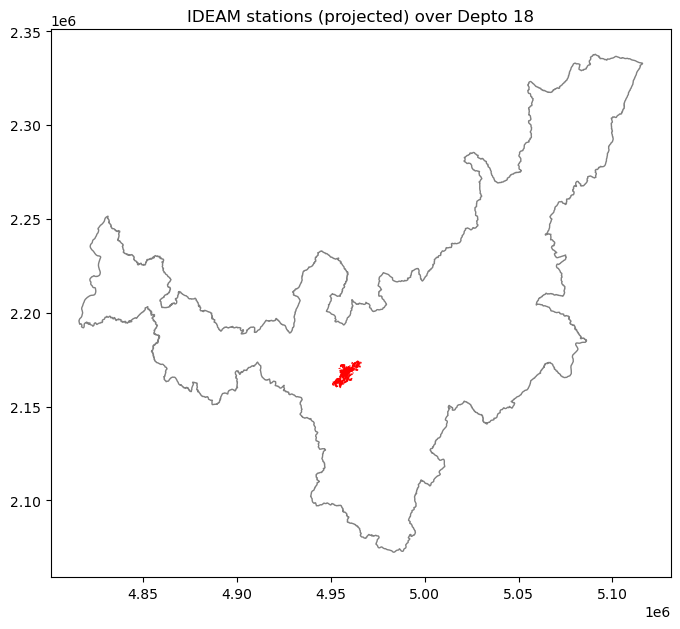

In [12]:
ax = Boyaca_poligono.plot(color="none", edgecolor="grey", figsize=(8, 8))
Boyaca_vias.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Depto 18")
plt.show()

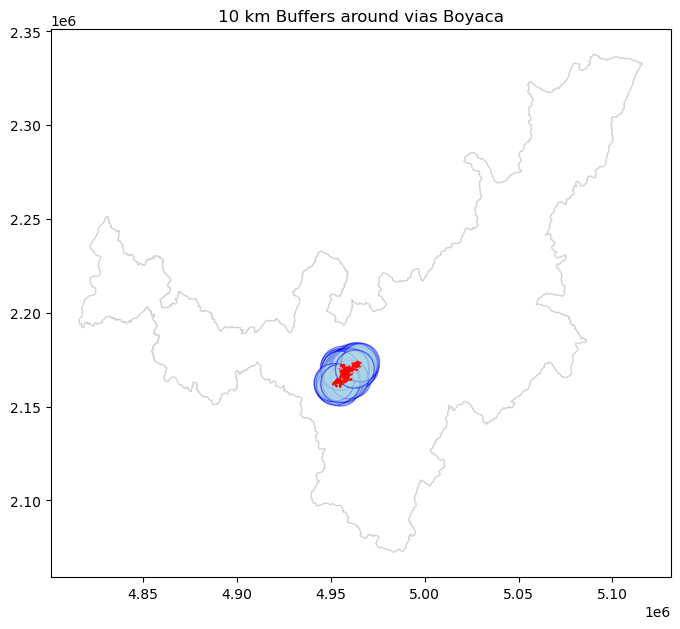

In [13]:

Boyaca_vias_copy = Boyaca_vias.copy()

# Create a 10 km buffer around each station
Boyaca_vias_copy['buffer_10km'] = Boyaca_vias_copy.geometry.buffer(10000)

# Visualise one example station buffer
ax = Boyaca_poligono.plot(color='none', edgecolor='lightgrey', figsize=(8, 8))

# Usa Boyaca_vias_copy para el buffer
gpd.GeoSeries(Boyaca_vias_copy['buffer_10km']).plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.5)
Boyaca_vias_copy.plot(ax=ax, color='red', markersize=20) # También usa la copia aquí

plt.title("10 km Buffers around vias Boyaca")
plt.show()

In [14]:
Boyaca_poligono.head()

,geometry,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_PRIM,STP51_SECU,STP51_SUPE,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,DPTO_CCDGO_NUM
DPTO_CCDGO,,,,,,,,,,,,,,,,,,,,,
15,"POLYGON ((4950411.628 2098204.312, 4950368.451...",00001,TUNJA,15001,2018,1.196889e+08,5.518473,-73.378019,79594.0,0.0,...,35470.0,56563.0,43652.0,14337.0,3156.0,4044.0,0.572327,0.009766,15001,15


In [15]:
# 1. Spatial join: each station takes the attributes of the municipality it falls in
stations_with_mun = gpd.sjoin(
    Boyaca_stations,                     # left: point layer
    gdf_mun[["MPIO_CCDGO", "MPIO_CNMBR","MPIO_CCDGO", "geometry"]],  # right: polygon layer
    how="left",
    predicate="within"           # point inside polygon
)

# 2. Inspect the result
stations_with_mun[["Codigo", "MPIO_CNMBR", "MPIO_CCDGO"]].head()

,Codigo,MPIO_CNMBR,MPIO_CCDGO,MPIO_CCDGO
2018,24035130,TUNJA,00001,00001
4205,2401500086,TUNJA,00001,00001
6433,24030900,TUNJA,00001,00001
6445,24030920,TUNJA,00001,00001
8410,24030910,TUNJA,00001,00001


In [16]:
import numpy as np
import shapely

# Create a regular grid covering Colombia

# Bounds of the municipalities layer
bounds = gdf_mun.total_bounds
xmin, ymin, xmax, ymax = bounds

# Define grid resolution (example: 100 km x 100 km grid → 100_000 m)
res = 100000

# Build grid coordinates
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax + res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax + res)), res))
rows.reverse()

# Build polygons for each grid cell
polygons = []
for x in cols:
    for y in rows:
        polygons.append(
            shapely.Polygon([
                (x, y),
                (x + res, y),
                (x + res, y - res),
                (x, y - res)
            ])
        )

# Create grid GeoDataFrame
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_mun.crs)

# Remove cells that fall outside the total extent (intersect municipalities only)
sel = grid.intersects(shapely.box(*bounds))
grid = grid[sel]

# Add unique ID
grid['id'] = grid.index

grid.head()

,geometry,id
0,"POLYGON ((4047822 3090086, 4147822 3090086, 41...",0
1,"POLYGON ((4047822 2990086, 4147822 2990086, 41...",1
2,"POLYGON ((4047822 2890086, 4147822 2890086, 41...",2
3,"POLYGON ((4047822 2790086, 4147822 2790086, 41...",3
4,"POLYGON ((4047822 2690086, 4147822 2690086, 41...",4


In [17]:
eva.head()

,CÓD. \nDEP.,DEPARTAMENTO,cod_mun,MUNICIPIO,GRUPO \nDE CULTIVO,SUBGRUPO \nDE CULTIVO,CULTIVO,DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO,AÑO,PERIODO,Área Sembrada\n(ha),Área Cosechada\n(ha),Producción\n(t),Rendimiento\n(t/ha),ESTADO FISICO PRODUCCION,NOMBRE \nCIENTIFICO,CICLO DE CULTIVO
0,15,BOYACA,15114,BUSBANZA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,2,1,1,1.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
1,25,CUNDINAMARCA,25754,SOACHA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,82,80,1440,18.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
2,25,CUNDINAMARCA,25214,COTA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,2,2,26,17.33,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
3,54,NORTE DE SANTANDER,54405,LOS PATIOS,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,3,3,48,16.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
4,54,NORTE DE SANTANDER,54518,PAMPLONA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,1,1,5,10.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO


In [18]:
print(type(eva))

<class 'pandas.core.frame.DataFrame'>


In [19]:
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]        = eva["cod_mun"].astype(str).str.zfill(5)

In [20]:
# Calculate polygon area in square metres
gdf_vias['longitud'] = gdf_vias.length

gdf_vias.head()

,TIPO_VIA,ESTADO_SUP,NUMERO_CAR,ACCESIBILI,NOMBRE_GEO,PROYECTO,SYMBOL,FECHA,RULEID,PK_CUE,GLOBALID,EJE_VIAL,SHAPE_Leng,geometry,longitud
0,4,3306,3502,3600,<Null>,None,2,0000/00/00,4,6941149.0,{F25CEF82-A74B-44C7-BA1F-875D53B40633},None,9137.640673,"LINESTRING (4938813.822 2008654.982, 4939350.5...",9137.640673
1,1,3301,3501,3600,None,None,2,0000/00/00,1,2076843.0,{3553ECE2-56ED-45B1-BA51-2ECE88213217},None,7744.347798,"LINESTRING (4935376.98 2015283.87, 4936592.897...",7744.347798
2,1,3301,3501,3600,None,None,2,0000/00/00,1,1969851.0,{ED19F1EF-41C1-494E-A383-6A80FB377DF0},None,67046.435973,"LINESTRING (4914689.09 1993685.711, 4914705.81...",67046.435973
3,3,3301,3502,3600,None,None,2,0000/00/00,3,1969852.0,{A4ADF111-9441-4424-B31C-AB6839103435},None,1004.968141,"LINESTRING (4941162.794 2007465.638, 4940399.1...",1004.968141
4,4,3306,3502,3600,None,None,2,0000/00/00,4,1969853.0,{FB0921F6-EA65-4ABD-8979-EA98E0B93955},None,29460.903727,"LINESTRING (4917686.375 1999922.108, 4917887.8...",29460.903727


In [21]:
vias_with_mun = gpd.sjoin(
    gdf_mun,                     # left: point layer
    gdf_vias[["longitud", "geometry"]],  # right: polygon layer
    how="left",
    predicate="intersects"           # point inside polygon
)

# 2. Inspect the result
vias_with_mun.head()


,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,DPTO_CCDGO_NUM,index_right,longitud
0,18,00001,FLORENCIA,18001,2018,2.547638e+09,1.749139,-75.558239,71877.0,32.0,...,4592.0,5892.0,3799.0,2.942508,0.206928,18001,"POLYGON ((4730856.146 1800689.038, 4730891.264...",18,4518.0,11542.910245
0,18,00001,FLORENCIA,18001,2018,2.547638e+09,1.749139,-75.558239,71877.0,32.0,...,4592.0,5892.0,3799.0,2.942508,0.206928,18001,"POLYGON ((4730856.146 1800689.038, 4730891.264...",18,99508.0,2249.232181
0,18,00001,FLORENCIA,18001,2018,2.547638e+09,1.749139,-75.558239,71877.0,32.0,...,4592.0,5892.0,3799.0,2.942508,0.206928,18001,"POLYGON ((4730856.146 1800689.038, 4730891.264...",18,99510.0,988.618694
0,18,00001,FLORENCIA,18001,2018,2.547638e+09,1.749139,-75.558239,71877.0,32.0,...,4592.0,5892.0,3799.0,2.942508,0.206928,18001,"POLYGON ((4730856.146 1800689.038, 4730891.264...",18,4811.0,322.227090
0,18,00001,FLORENCIA,18001,2018,2.547638e+09,1.749139,-75.558239,71877.0,32.0,...,4592.0,5892.0,3799.0,2.942508,0.206928,18001,"POLYGON ((4730856.146 1800689.038, 4730891.264...",18,4808.0,365.837211


In [ ]:
gdf_interseccion = gdf_mun.overlay(vias_with_mun, how='intersection')
gdf_interseccion.head()

In [ ]:
mun_grid = gdf_interseccion.overlay(grid)

# Keep only needed columns
mun_grid = mun_grid[['MPIO_CNMBR', 'longitud', 'geometry']]

# Compute the area of each piece (intersection area)
mun_grid['area_sub'] = mun_grid.area

mun_grid.head()

In [ ]:
ax = mun_grid.plot(
    column='area_sub',
    edgecolor='black',
    legend=True,
    cmap='Reds',
    figsize=(10, 10),
    vmin=100000000,
    vmax=10000000000
)

# Title
plt.title("Effect of .overlay:")
plt.show()